In [1]:
import numpy as np

In [3]:
%pip install pandas opencv-python matplotlib pyarrow

   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
   ------ --------------------------------- 1.8/11.3 MB 14.3 MB/s eta 0:00:01
   ------------- -------------------------- 3.9/11.3 MB 10.7 MB/s eta 0:00:01
   ------------------ --------------------- 5.2/11.3 MB 9.4 MB/s eta 0:00:01
   ----------------------- ---------------- 6.6/11.3 MB 8.4 MB/s eta 0:00:01
   -------------------------- ------------- 7.6/11.3 MB 7.6 MB/s eta 0:00:01
   ------------------------------ --------- 8.7/11.3 MB 7.1 MB/s eta 0:00:01
   ---------------------------------- ----- 9.7/11.3 MB 6.8 MB/s eta 0:00:01
   ------------------------------------- -- 10.7/11.3 MB 6.6 MB/s eta 0:00:01
   ---------------------------------------- 11.3/11.3 MB 6.2 MB/s  0:00:01
   ---------------------------------------- 0.0/40.2 MB ? eta -:--:--
   - -------------------------------------- 1.0/40.2 MB 5.6 MB/s eta 0:00:07
   -- ------------------------------------- 2.1/40.2 MB 5.3 MB/s eta 0:00:08
   -- ------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.5.0 requires fsspec[http]<=2025.10.0,>=2023.1.0, but you have fsspec 2026.1.0 which is incompatible.
tensorboard 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.25.3 which is incompatible.
tensorflow 2.10.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.25.3 which is incompatible.
transformers 4.57.6 requires tokenizers<=0.23.0,>=0.22.0, but you have tokenizers 0.19.1 which is incompatible.

[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import pyarrow as pa

Columns found: Index(['image', 'label'], dtype='object')

First row data sample:
image    {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...
label    {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...
Name: 0, dtype: object


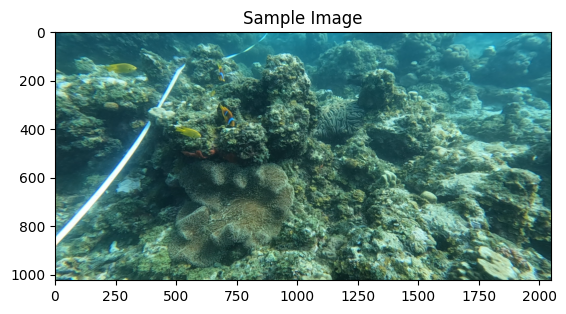

In [2]:
import pandas as pd
import io
from PIL import Image

# Update this path to where one of your downloaded parquet files is located
parquet_path = "coralscapes (2)\\coralscapes\\data\\train-00000-of-00009.parquet" 

# Read just a small piece of the file to save RAM
df_sample = pd.read_parquet(parquet_path)

print("Columns found:", df_sample.columns)
print("\nFirst row data sample:")
print(df_sample.iloc[0])

# Let's try to display the first image to ensure it works
import matplotlib.pyplot as plt

# Assuming the column is named 'image' and contains bytes
# Note: You might need to adjust 'image' to 'img' or whatever the print command above revealed
try:
    image_bytes = df_sample.iloc[0]['image']['bytes'] 
    image = Image.open(io.BytesIO(image_bytes))
    plt.imshow(image)
    plt.title("Sample Image")
    plt.show()
except Exception as e:
    print(f"Could not display image directly: {e}")

In [7]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import io
import json
from PIL import Image

# --- CONFIGURATION ---
PARQUET_FOLDER = "coralscapes (2)\\coralscapes\\data"
OUTPUT_DIR = "dataset_yolo_seg"

# Load the ACTUAL class mapping from your dataset
with open("coralscapes (2)\\coralscapes\\id2label.json", "r") as f:
    id2label = json.load(f)

# Convert to proper format (keys are strings in JSON)
ID2LABEL = {int(k): v for k, v in id2label.items()}

# Create YOLO class mapping (0-indexed)
NUM_CLASSES = len(ID2LABEL)
CLASSES = [ID2LABEL[i] for i in range(1, NUM_CLASSES + 1)]

print(f"Loaded {NUM_CLASSES} classes from id2label.json")

# Create directories (clear old labels first)
import shutil
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
    
for split in ['train', 'val']:
    os.makedirs(os.path.join(OUTPUT_DIR, 'images', split), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, 'labels', split), exist_ok=True)

def binary_mask_to_polygon(mask, min_area=50, epsilon_factor=0.001):
    """
    Converts a binary mask (0/255) into normalized YOLO polygon coordinates.
    """
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    polygons = []
    H, W = mask.shape
    
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > min_area:
            # Simplify contour to reduce points
            epsilon = epsilon_factor * cv2.arcLength(cnt, True)
            cnt = cv2.approxPolyDP(cnt, epsilon, True)
            
            # Need at least 3 points for a valid polygon
            if len(cnt) >= 3:
                polygon = []
                for point in cnt:
                    x, y = point[0]
                    # Normalize coordinates (0-1 range), clamp to valid range
                    polygon.append(max(0, min(1, x / W)))
                    polygon.append(max(0, min(1, y / H)))
                polygons.append(polygon)
    return polygons

def process_parquet_file(file_path, split_type="train"):
    df = pd.read_parquet(file_path)
    
    print(f"\nProcessing {len(df)} images from {os.path.basename(file_path)}...")
    
    labels_written = 0
    empty_labels = 0
    
    for index, row in tqdm(df.iterrows(), total=len(df)):
        try:
            # 1. EXTRACT IMAGE
            img_bytes = row['image']['bytes'] 
            image = Image.open(io.BytesIO(img_bytes)).convert('RGB')
            
            # Save Image
            filename = f"{os.path.splitext(os.path.basename(file_path))[0]}_{index}"
            image_path = os.path.join(OUTPUT_DIR, 'images', split_type, f"{filename}.jpg")
            image.save(image_path, "JPEG")
            
            # 2. EXTRACT MASK FROM 'label' COLUMN (not 'segmentation'!)
            label_path = os.path.join(OUTPUT_DIR, 'labels', split_type, f"{filename}.txt")
            
            label_lines = []
            
            # The mask is in the 'label' column!
            if 'label' in row and row['label'] is not None:
                mask_bytes = row['label']['bytes']
                mask = Image.open(io.BytesIO(mask_bytes))
                mask_np = np.array(mask)
                
                # Get unique class IDs in this mask (dataset uses 1-39)
                unique_classes = np.unique(mask_np)
                
                for dataset_cls_id in unique_classes:
                    # Skip if class ID is 0 or out of range
                    if dataset_cls_id < 1 or dataset_cls_id > NUM_CLASSES:
                        continue
                    
                    # Convert dataset class ID (1-39) to YOLO class ID (0-38)
                    yolo_cls_id = dataset_cls_id - 1
                    
                    # Create binary mask for this class
                    binary_mask = (mask_np == dataset_cls_id).astype(np.uint8) * 255
                    
                    # Convert to polygons
                    polygons = binary_mask_to_polygon(binary_mask)
                    
                    for poly in polygons:
                        if len(poly) >= 6:  # At least 3 points (6 coordinates)
                            poly_str = " ".join([f"{p:.6f}" for p in poly])
                            label_lines.append(f"{yolo_cls_id} {poly_str}")
            
            # Write label file
            with open(label_path, 'w') as f:
                if label_lines:
                    f.write("\n".join(label_lines))
                    labels_written += 1
                else:
                    empty_labels += 1
                            
        except Exception as e:
            print(f"Error processing row {index}: {e}")
    
    print(f"  ✓ Labels with annotations: {labels_written}")
    print(f"  ✗ Empty labels: {empty_labels}")

# --- EXECUTION ---
import glob
train_files = glob.glob(os.path.join(PARQUET_FOLDER, "train-*.parquet"))
val_files = glob.glob(os.path.join(PARQUET_FOLDER, "validation-*.parquet"))

print(f"\nFound {len(train_files)} training files and {len(val_files)} validation files")

# Run the processing
for p_file in train_files:
    process_parquet_file(p_file, split_type="train")

for p_file in val_files:
    process_parquet_file(p_file, split_type="val")

print("\n" + "="*60)
print("✅ Conversion Complete!")
print("="*60)

# Verify labels
train_labels = glob.glob(os.path.join(OUTPUT_DIR, 'labels', 'train', '*.txt'))
val_labels = glob.glob(os.path.join(OUTPUT_DIR, 'labels', 'val', '*.txt'))

non_empty_train = sum(1 for f in train_labels if os.path.getsize(f) > 0)
non_empty_val = sum(1 for f in val_labels if os.path.getsize(f) > 0)

print(f"Train: {non_empty_train}/{len(train_labels)} labels with annotations")
print(f"Val: {non_empty_val}/{len(val_labels)} labels with annotations")

# Show sample label
sample_labels = [f for f in train_labels if os.path.getsize(f) > 0]
if sample_labels:
    with open(sample_labels[0], 'r') as f:
        content = f.read()
        lines = content.split('\n')
        print(f"\nSample label ({os.path.basename(sample_labels[0])}):")
        print(f"  Total annotations: {len(lines)}")
        print(f"  First 3 lines:")
        for line in lines[:3]:
            parts = line.split()
            if parts:
                cls_id = int(parts[0])
                print(f"    Class {cls_id} ({CLASSES[cls_id]}): {len(parts)-1} polygon points")

Loaded 39 classes from id2label.json

Found 9 training files and 1 validation files

Processing 169 images from train-00000-of-00009.parquet...


100%|██████████| 169/169 [00:36<00:00,  4.60it/s]


  ✓ Labels with annotations: 169
  ✗ Empty labels: 0

Processing 169 images from train-00001-of-00009.parquet...


100%|██████████| 169/169 [00:36<00:00,  4.57it/s]


  ✓ Labels with annotations: 169
  ✗ Empty labels: 0

Processing 169 images from train-00002-of-00009.parquet...


100%|██████████| 169/169 [00:37<00:00,  4.46it/s]


  ✓ Labels with annotations: 169
  ✗ Empty labels: 0

Processing 169 images from train-00003-of-00009.parquet...


100%|██████████| 169/169 [00:37<00:00,  4.52it/s]


  ✓ Labels with annotations: 169
  ✗ Empty labels: 0

Processing 169 images from train-00004-of-00009.parquet...


100%|██████████| 169/169 [00:38<00:00,  4.44it/s]


  ✓ Labels with annotations: 169
  ✗ Empty labels: 0

Processing 168 images from train-00005-of-00009.parquet...


100%|██████████| 168/168 [00:35<00:00,  4.71it/s]


  ✓ Labels with annotations: 168
  ✗ Empty labels: 0

Processing 168 images from train-00006-of-00009.parquet...


100%|██████████| 168/168 [00:34<00:00,  4.81it/s]


  ✓ Labels with annotations: 168
  ✗ Empty labels: 0

Processing 168 images from train-00007-of-00009.parquet...


100%|██████████| 168/168 [00:38<00:00,  4.40it/s]


  ✓ Labels with annotations: 168
  ✗ Empty labels: 0

Processing 168 images from train-00008-of-00009.parquet...


100%|██████████| 168/168 [00:36<00:00,  4.55it/s]


  ✓ Labels with annotations: 168
  ✗ Empty labels: 0

Processing 166 images from validation-00000-of-00001.parquet...


100%|██████████| 166/166 [00:34<00:00,  4.81it/s]


  ✓ Labels with annotations: 166
  ✗ Empty labels: 0

✅ Conversion Complete!
Train: 1517/1517 labels with annotations
Val: 166/166 labels with annotations

Sample label (train-00000-of-00009_0.txt):
  Total annotations: 71
  First 3 lines:
    Class 8 (fish): 272 polygon points
    Class 8 (fish): 234 polygon points
    Class 8 (fish): 70 polygon points


# Step 3: Create YOLO Dataset Configuration
Create the `data.yaml` file required for YOLO training

In [8]:
import os
import json

# Load the ACTUAL class mapping from your dataset
with open("coralscapes (2)\\coralscapes\\id2label.json", "r") as f:
    id2label = json.load(f)

# Convert to ordered list for YOLO (0-indexed)
# Dataset classes are 1-39, YOLO needs 0-38
NUM_CLASSES = len(id2label)
CLASSES = [id2label[str(i)] for i in range(1, NUM_CLASSES + 1)]

print(f"Loaded {NUM_CLASSES} classes from id2label.json")

# Create data.yaml for YOLO
dataset_path = os.path.abspath("dataset_yolo_seg")

yaml_content = f"""# Coral Bleach Detection Dataset (Coralscapes)
path: {dataset_path}
train: images/train
val: images/val

# Number of classes
nc: {NUM_CLASSES}

# Class names (YOLO class 0 = dataset class 1, etc.)
names:
"""

for i, cls_name in enumerate(CLASSES):
    yaml_content += f"  {i}: {cls_name}\n"

# Write the yaml file
with open("coral_dataset.yaml", "w") as f:
    f.write(yaml_content)

print("\nCreated coral_dataset.yaml")
print(yaml_content)

Loaded 39 classes from id2label.json

Created coral_dataset.yaml
# Coral Bleach Detection Dataset (Coralscapes)
path: c:\Users\modij\OneDrive\Desktop\coral_bleach_detector\dataset_yolo_seg
train: images/train
val: images/val

# Number of classes
nc: 39

# Class names (YOLO class 0 = dataset class 1, etc.)
names:
  0: seagrass
  1: trash
  2: other coral dead
  3: other coral bleached
  4: sand
  5: other coral alive
  6: human
  7: transect tools
  8: fish
  9: algae covered substrate
  10: other animal
  11: unknown hard substrate
  12: background
  13: dark
  14: transect line
  15: massive/meandering bleached
  16: massive/meandering alive
  17: rubble
  18: branching bleached
  19: branching dead
  20: millepora
  21: branching alive
  22: massive/meandering dead
  23: clam
  24: acropora alive
  25: sea cucumber
  26: turbinaria
  27: table acropora alive
  28: sponge
  29: anemone
  30: pocillopora alive
  31: table acropora dead
  32: meandering bleached
  33: stylophora alive
 

# Step 4: Install Ultralytics and Train YOLOv8-seg Model
YOLOv8-seg provides excellent real-time segmentation performance ideal for AR/camera applications

In [2]:
%pip install ultralytics

   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 9.8 MB/s  0:00:00
   ---------------------------------------- 0.0/113.7 MB ? eta -:--:--
    --------------------------------------- 1.6/113.7 MB 9.3 MB/s eta 0:00:13
    --------------------------------------- 2.6/113.7 MB 6.3 MB/s eta 0:00:18
   - -------------------------------------- 3.4/113.7 MB 5.6 MB/s eta 0:00:20
   - -------------------------------------- 4.2/113.7 MB 5.3 MB/s eta 0:00:21
   - -------------------------------------- 5.0/113.7 MB 4.7 MB/s eta 0:00:24
   -- ------------------------------------- 5.8/113.7 MB 4.3 MB/s eta 0:00:25
   -- ------------------------------------- 6.3/113.7 MB 4.2 MB/s eta 0:00:26
   -- ------------------------------------- 7.1/113.7 MB 4.2 MB/s eta 0:00:26
   -- ------------------------------------- 7.6/113.7 MB 4.1 MB/s eta 0:00:26
   -- ------------------------------------- 8.4/113.7 MB 3.9 MB/s eta 0:00:27
   --- 


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import torch
import gc
import os

# Clear GPU memory and garbage collect
gc.collect()
torch.cuda.empty_cache()

# Disable multiprocessing on Windows to avoid DataLoader issues
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

from ultralytics import YOLO

# Load the YOLOv8 medium segmentation model
model = YOLO('yolov8m-seg.pt')

# Train with conservative settings for Windows stability
results = model.train(
    data='coral_dataset.yaml',
    epochs=50,               # Reduced epochs for stability
    imgsz=512,               # Smaller image size for memory
    batch=2,                 # Smaller batch size
    device=0,                # Use GPU
    project='runs/segment/coral_detector',
    name='yolov8m_seg_final',
    exist_ok=True,
    workers=0,               # Disable multiprocessing (Windows fix)
    amp=True,                # Mixed precision for memory efficiency
    cache=False,             # Don't cache to save memory
    patience=10,             # Early stopping
    verbose=True
)

print("Training completed!")
print(f"Best weights saved to: {model.trainer.best}")

Ultralytics 8.4.10  Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=2, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=coral_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=yolov8m_seg_final, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pa

: 

# Step 5: Evaluate and Export Model
Export the trained model for different deployment targets

In [2]:
from ultralytics import YOLO
import os

# Path to the trained model
MODEL_PATH = r"C:\Users\modij\OneDrive\Desktop\coral_bleach_detector\runs\segment\runs\segment\coral_detector\yolov8m_seg_final\weights\best.pt"

print(f"Loading model from: {MODEL_PATH}")
print(f"Model exists: {os.path.exists(MODEL_PATH)}")

# Load best trained model
best_model = YOLO(MODEL_PATH)

# Validate on validation set
print("\n📊 Running validation...")
metrics = best_model.val()
print(f"\n✅ Validation Results:")
print(f"   mAP50 (Segmentation): {metrics.seg.map50:.4f}")
print(f"   mAP50-95 (Segmentation): {metrics.seg.map:.4f}")
print(f"   mAP50 (Box): {metrics.box.map50:.4f}")
print(f"   mAP50-95 (Box): {metrics.box.map:.4f}")

# Export for different platforms
print("\n📦 Exporting models for deployment...")

# 1. ONNX - For web deployment (ONNX.js) and cross-platform
onnx_path = best_model.export(format="onnx", imgsz=512, simplify=True)
print(f"   ✅ ONNX exported: {onnx_path}")

# 2. TorchScript - For PyTorch mobile/deployment
torchscript_path = best_model.export(format="torchscript", imgsz=512)
print(f"   ✅ TorchScript exported: {torchscript_path}")

print("\n🎉 Models exported successfully!")
print(f"📁 Exported files location: {os.path.dirname(MODEL_PATH)}")

Loading model from: C:\Users\modij\OneDrive\Desktop\coral_bleach_detector\runs\segment\runs\segment\coral_detector\yolov8m_seg_final\weights\best.pt
Model exists: True

📊 Running validation...
Ultralytics 8.4.10  Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLOv8m-seg summary (fused): 106 layers, 27,244,965 parameters, 0 gradients, 104.4 GFLOPs
val: Fast image access  (ping: 0.20.0 ms, read: 130.921.6 MB/s, size: 179.9 KB)
val: Scanning C:\Users\modij\OneDrive\Desktop\coral_bleach_detector\dataset_yolo_seg\labels\val.cache... 166 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 166/166  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 1.2s/it 12.9s0.4s
                   all        166      11416      0.389      0.277      0.235      0.156      0.372      0.266      0.226      0.129
                 trash          2          5   

# Step 6: Real-Time Camera Detection (Desktop Testing)
Test the model with live webcam feed before deploying to mobile/AR

In [3]:
import cv2
from ultralytics import YOLO
import numpy as np

# Load the trained model
MODEL_PATH = r"C:\Users\modij\OneDrive\Desktop\coral_bleach_detector\runs\segment\runs\segment\coral_detector\yolov8m_seg_final\weights\best.pt"
model = YOLO(MODEL_PATH)

# Class colors for visualization (RGB)
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(40, 3), dtype=np.uint8)

def run_realtime_detection(source=0, conf_threshold=0.25):
    """
    Run real-time coral detection on camera feed
    
    Args:
        source: 0 for webcam, or path to video file, or URL for IP camera
        conf_threshold: Confidence threshold for detections
    """
    cap = cv2.VideoCapture(source)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    
    print("🎥 Camera started!")
    print("Press 'q' to quit, 's' to save screenshot")
    
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        
        # Run inference
        results = model.predict(
            frame, 
            conf=conf_threshold,
            verbose=False,
            retina_masks=True  # Higher quality masks
        )
        
        # Get annotated frame with masks
        annotated_frame = results[0].plot(
            line_width=2,
            font_size=0.6
        )
        
        # Add info overlay
        cv2.putText(annotated_frame, "CORAL BLEACH DETECTOR", (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
        
        # Display detection summary
        if results[0].boxes is not None:
            num_detections = len(results[0].boxes)
            cv2.putText(annotated_frame, f"Detections: {num_detections}", (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            
            # Show class breakdown
            if num_detections > 0:
                classes = results[0].boxes.cls.cpu().numpy()
                names = results[0].names
                class_counts = {}
                for c in classes:
                    name = names[int(c)]
                    class_counts[name] = class_counts.get(name, 0) + 1
                
                y_offset = 90
                for name, count in list(class_counts.items())[:5]:
                    cv2.putText(annotated_frame, f"{name}: {count}", (10, y_offset),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
                    y_offset += 20
        
        cv2.imshow("Coral Bleach Detector - Press 'q' to quit", annotated_frame)
        
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('s'):
            filename = f"coral_screenshot_{frame_count}.jpg"
            cv2.imwrite(filename, annotated_frame)
            print(f"📸 Screenshot saved: {filename}")
    
    cap.release()
    cv2.destroyAllWindows()
    print("🛑 Camera stopped")

print("✅ Real-time detection function ready!")
print("\n📌 To start webcam detection, run:")
print("   run_realtime_detection(source=0)")
print("\n📌 To test on a video file:")
print("   run_realtime_detection(source='path/to/video.mp4')")
print("\n📌 For IP camera / phone stream:")
print("   run_realtime_detection(source='http://IP:PORT/video')")

✅ Real-time detection function ready!

📌 To start webcam detection, run:
   run_realtime_detection(source=0)

📌 To test on a video file:
   run_realtime_detection(source='path/to/video.mp4')

📌 For IP camera / phone stream:
   run_realtime_detection(source='http://IP:PORT/video')


# Step 7: Web-Based AR Detection (Recommended for Easy Deployment)
This creates a Flask web app that can be accessed from any device with a camera

In [4]:
# Create a web application for mobile/AR detection
# This allows users to access the detection from any device with a browser
import os
import json

# Correct model path
MODEL_PATH = r"runs\segment\runs\segment\coral_detector\yolov8m_seg_final\weights\best.pt"

# Get class names from YAML
CLASS_NAMES = [
    "seagrass", "trash", "other coral dead", "other coral bleached", "sand",
    "other coral alive", "human", "transect tools", "fish", "algae covered substrate",
    "other animal", "unknown hard substrate", "background", "dark", "transect line",
    "massive/meandering bleached", "massive/meandering alive", "rubble",
    "branching bleached", "branching dead", "millepora", "branching alive",
    "massive/meandering dead", "clam", "acropora alive", "sea cucumber",
    "turbinaria", "table acropora alive", "sponge", "anemone", "pocillopora alive",
    "table acropora dead", "meandering bleached", "stylophora alive", "sea urchin",
    "meandering alive", "meandering dead", "crown of thorn", "dead clam"
]

# Categories for health analysis
HEALTHY_CLASSES = [
    "massive/meandering alive", "other coral alive", "branching alive", 
    "acropora alive", "pocillopora alive", "table acropora alive",
    "stylophora alive", "meandering alive", "millepora", "turbinaria"
]
BLEACHED_CLASSES = [
    "other coral bleached", "branching bleached", "massive/meandering bleached", "meandering bleached"
]
DEAD_CLASSES = [
    "other coral dead", "massive/meandering dead", "branching dead", 
    "table acropora dead", "meandering dead"
]

webapp_code = f'''
from flask import Flask, render_template, Response, jsonify, request
from flask_cors import CORS
from ultralytics import YOLO
import cv2
import numpy as np
import base64
import io
from PIL import Image
import os

app = Flask(__name__)
CORS(app)

# Load model - use relative path from webapp folder
MODEL_PATH = os.path.join(os.path.dirname(os.path.dirname(__file__)), 
                          "runs", "segment", "runs", "segment", "coral_detector", 
                          "yolov8m_seg_final", "weights", "best.pt")
print(f"Loading model from: {{MODEL_PATH}}")
model = YOLO(MODEL_PATH)

# Class names from training
CLASS_NAMES = {json.dumps(CLASS_NAMES)}

# Categories for health analysis
HEALTHY_CLASSES = {json.dumps(HEALTHY_CLASSES)}
BLEACHED_CLASSES = {json.dumps(BLEACHED_CLASSES)}
DEAD_CLASSES = {json.dumps(DEAD_CLASSES)}

@app.route("/")
def index():
    return render_template("index.html")

@app.route("/analyze", methods=["POST"])
def analyze_image():
    """Analyze uploaded or captured image"""
    try:
        # Get image from request
        if "image" in request.files:
            file = request.files["image"]
            img = Image.open(file.stream)
        elif request.json and "image_data" in request.json:
            # Base64 encoded image from camera
            img_data = base64.b64decode(request.json["image_data"].split(",")[1])
            img = Image.open(io.BytesIO(img_data))
        else:
            return jsonify({{"error": "No image provided"}}), 400
        
        # Convert to numpy array
        img_np = np.array(img.convert("RGB"))
        
        # Run detection
        results = model.predict(img_np, conf=0.25, retina_masks=True, verbose=False)
        
        # Get annotated image
        annotated = results[0].plot()
        
        # Calculate health metrics
        health_analysis = analyze_coral_health(results[0])
        
        # Convert annotated image to base64
        annotated_bgr = cv2.cvtColor(annotated, cv2.COLOR_RGB2BGR)
        _, buffer = cv2.imencode(".jpg", annotated_bgr, [cv2.IMWRITE_JPEG_QUALITY, 90])
        img_base64 = base64.b64encode(buffer).decode("utf-8")
        
        return jsonify({{
            "success": True,
            "annotated_image": f"data:image/jpeg;base64,{{img_base64}}",
            "health_analysis": health_analysis
        }})
        
    except Exception as e:
        import traceback
        traceback.print_exc()
        return jsonify({{"error": str(e)}}), 500

def analyze_coral_health(result):
    """Analyze coral health from detection results"""
    health_stats = {{
        "total_corals": 0,
        "healthy_count": 0,
        "bleached_count": 0,
        "dead_count": 0,
        "health_score": 0,
        "status": "Unknown",
        "detections": []
    }}
    
    if result.boxes is None or len(result.boxes) == 0:
        health_stats["status"] = "No corals detected"
        return health_stats
    
    names = result.names  # Get names from model
    
    for i, box in enumerate(result.boxes):
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        cls_name = names.get(cls_id, f"Class {{cls_id}}")
        
        detection = {{"class": cls_name, "confidence": round(conf * 100, 1)}}
        health_stats["detections"].append(detection)
        
        if cls_name in HEALTHY_CLASSES:
            health_stats["healthy_count"] += 1
            health_stats["total_corals"] += 1
        elif cls_name in BLEACHED_CLASSES:
            health_stats["bleached_count"] += 1
            health_stats["total_corals"] += 1
        elif cls_name in DEAD_CLASSES:
            health_stats["dead_count"] += 1
            health_stats["total_corals"] += 1
    
    # Calculate health score
    if health_stats["total_corals"] > 0:
        healthy_pct = health_stats["healthy_count"] / health_stats["total_corals"]
        bleached_pct = health_stats["bleached_count"] / health_stats["total_corals"]
        
        # Health score: 100 = all healthy, 0 = all dead
        health_stats["health_score"] = round((healthy_pct * 100) + (bleached_pct * 50), 1)
        
        if healthy_pct > 0.7:
            health_stats["status"] = "🟢 Healthy Reef"
        elif healthy_pct > 0.4:
            health_stats["status"] = "🟡 Moderate Stress"
        elif bleached_pct > 0.3:
            health_stats["status"] = "🟠 Significant Bleaching"
        else:
            health_stats["status"] = "🔴 Critical Condition"
    
    return health_stats

if __name__ == "__main__":
    print("\\n🌊 Coral Bleach Detector Web App")
    print("=" * 40)
    print("Open http://localhost:5000 in your browser")
    print("=" * 40)
    app.run(host="0.0.0.0", port=5000, debug=False)
'''

# Save the Flask app
os.makedirs("webapp", exist_ok=True)
os.makedirs("webapp/templates", exist_ok=True)

with open("webapp/app.py", "w") as f:
    f.write(webapp_code)

print("✅ Flask app created at webapp/app.py")

✅ Flask app created at webapp/app.py


In [5]:
# Create the HTML template with camera access and AR overlay

html_template = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Coral Bleach Detector - AR</title>
    <style>
        * { margin: 0; padding: 0; box-sizing: border-box; }
        body {
            font-family: 'Segoe UI', Tahoma, sans-serif;
            background: linear-gradient(135deg, #1a1a2e 0%, #16213e 100%);
            min-height: 100vh;
            color: white;
        }
        .container {
            max-width: 1200px;
            margin: 0 auto;
            padding: 20px;
        }
        h1 {
            text-align: center;
            padding: 20px;
            background: linear-gradient(90deg, #00d4ff, #00ff88);
            -webkit-background-clip: text;
            -webkit-text-fill-color: transparent;
            font-size: 2.5rem;
        }
        .camera-section {
            display: flex;
            flex-wrap: wrap;
            gap: 20px;
            justify-content: center;
            margin: 20px 0;
        }
        .video-container {
            position: relative;
            border-radius: 15px;
            overflow: hidden;
            box-shadow: 0 10px 40px rgba(0,212,255,0.3);
        }
        #video, #result-image {
            max-width: 100%;
            width: 640px;
            height: auto;
            display: block;
        }
        .controls {
            display: flex;
            gap: 10px;
            justify-content: center;
            flex-wrap: wrap;
            margin: 20px 0;
        }
        button {
            padding: 15px 30px;
            font-size: 1.1rem;
            border: none;
            border-radius: 50px;
            cursor: pointer;
            transition: all 0.3s ease;
            font-weight: bold;
        }
        .btn-capture {
            background: linear-gradient(90deg, #00d4ff, #00ff88);
            color: #1a1a2e;
        }
        .btn-capture:hover {
            transform: scale(1.05);
            box-shadow: 0 5px 20px rgba(0,212,255,0.5);
        }
        .btn-upload {
            background: #2d3748;
            color: white;
            border: 2px solid #00d4ff;
        }
        .health-panel {
            background: rgba(255,255,255,0.1);
            border-radius: 15px;
            padding: 20px;
            margin: 20px 0;
            backdrop-filter: blur(10px);
        }
        .health-score {
            font-size: 3rem;
            text-align: center;
            margin: 20px 0;
        }
        .status {
            text-align: center;
            font-size: 1.5rem;
            padding: 10px;
            border-radius: 10px;
            margin: 10px 0;
        }
        .stats-grid {
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(150px, 1fr));
            gap: 15px;
            margin: 20px 0;
        }
        .stat-card {
            background: rgba(0,0,0,0.3);
            padding: 15px;
            border-radius: 10px;
            text-align: center;
        }
        .stat-value {
            font-size: 2rem;
            font-weight: bold;
        }
        .healthy { color: #00ff88; }
        .bleached { color: #ffaa00; }
        .dead { color: #ff4444; }
        .loading {
            display: none;
            text-align: center;
            padding: 20px;
        }
        .spinner {
            border: 4px solid #f3f3f3;
            border-top: 4px solid #00d4ff;
            border-radius: 50%;
            width: 50px;
            height: 50px;
            animation: spin 1s linear infinite;
            margin: 0 auto;
        }
        @keyframes spin {
            0% { transform: rotate(0deg); }
            100% { transform: rotate(360deg); }
        }
        .detection-list {
            max-height: 200px;
            overflow-y: auto;
            margin-top: 15px;
        }
        .detection-item {
            display: flex;
            justify-content: space-between;
            padding: 8px;
            background: rgba(0,0,0,0.2);
            margin: 5px 0;
            border-radius: 5px;
        }
        #file-input { display: none; }
    </style>
</head>
<body>
    <div class="container">
        <h1>🐠 Coral Bleach Detector</h1>
        
        <div class="camera-section">
            <div class="video-container">
                <video id="video" autoplay playsinline></video>
                <img id="result-image" style="display: none;">
            </div>
        </div>
        
        <div class="controls">
            <button class="btn-capture" onclick="captureAndAnalyze()">📸 Capture & Analyze</button>
            <button class="btn-upload" onclick="document.getElementById('file-input').click()">📁 Upload Image</button>
            <button class="btn-upload" onclick="showCamera()">🔄 New Capture</button>
            <input type="file" id="file-input" accept="image/*" onchange="uploadImage(event)">
        </div>
        
        <div class="loading" id="loading">
            <div class="spinner"></div>
            <p>Analyzing coral health...</p>
        </div>
        
        <div class="health-panel" id="results" style="display: none;">
            <h2>🔬 Analysis Results</h2>
            
            <div class="health-score">
                Health Score: <span id="health-score">--</span>/100
            </div>
            
            <div class="status" id="status">--</div>
            
            <div class="stats-grid">
                <div class="stat-card">
                    <div class="stat-value healthy" id="healthy-count">0</div>
                    <div>Healthy Corals</div>
                </div>
                <div class="stat-card">
                    <div class="stat-value bleached" id="bleached-count">0</div>
                    <div>Bleached Corals</div>
                </div>
                <div class="stat-card">
                    <div class="stat-value dead" id="dead-count">0</div>
                    <div>Dead Corals</div>
                </div>
                <div class="stat-card">
                    <div class="stat-value" id="total-count">0</div>
                    <div>Total Detected</div>
                </div>
            </div>
            
            <h3>Detections:</h3>
            <div class="detection-list" id="detection-list"></div>
        </div>
    </div>
    
    <canvas id="canvas" style="display: none;"></canvas>
    
    <script>
        const video = document.getElementById('video');
        const canvas = document.getElementById('canvas');
        const resultImage = document.getElementById('result-image');
        
        // Start camera
        async function startCamera() {
            try {
                const stream = await navigator.mediaDevices.getUserMedia({
                    video: { facingMode: 'environment', width: 1280, height: 720 }
                });
                video.srcObject = stream;
            } catch (err) {
                alert('Camera access denied. Please enable camera permissions.');
            }
        }
        
        function showCamera() {
            video.style.display = 'block';
            resultImage.style.display = 'none';
            document.getElementById('results').style.display = 'none';
        }
        
        async function captureAndAnalyze() {
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            
            const imageData = canvas.toDataURL('image/jpeg', 0.9);
            await analyzeImage(imageData);
        }
        
        async function uploadImage(event) {
            const file = event.target.files[0];
            if (!file) return;
            
            const reader = new FileReader();
            reader.onload = async (e) => {
                await analyzeImage(e.target.result);
            };
            reader.readAsDataURL(file);
        }
        
        async function analyzeImage(imageData) {
            document.getElementById('loading').style.display = 'block';
            document.getElementById('results').style.display = 'none';
            
            try {
                const response = await fetch('/analyze', {
                    method: 'POST',
                    headers: { 'Content-Type': 'application/json' },
                    body: JSON.stringify({ image_data: imageData })
                });
                
                const data = await response.json();
                
                if (data.success) {
                    // Show annotated image
                    video.style.display = 'none';
                    resultImage.src = data.annotated_image;
                    resultImage.style.display = 'block';
                    
                    // Update health panel
                    const health = data.health_analysis;
                    document.getElementById('health-score').textContent = health.health_score;
                    document.getElementById('status').textContent = health.status;
                    document.getElementById('healthy-count').textContent = health.healthy_count;
                    document.getElementById('bleached-count').textContent = health.bleached_count;
                    document.getElementById('dead-count').textContent = health.dead_count;
                    document.getElementById('total-count').textContent = health.total_corals;
                    
                    // Show detections list
                    const detectionList = document.getElementById('detection-list');
                    detectionList.innerHTML = health.detections.map(d => 
                        `<div class="detection-item">
                            <span>${d.class}</span>
                            <span>${d.confidence}%</span>
                        </div>`
                    ).join('');
                    
                    document.getElementById('results').style.display = 'block';
                } else {
                    alert('Analysis failed: ' + data.error);
                }
            } catch (err) {
                alert('Error: ' + err.message);
            }
            
            document.getElementById('loading').style.display = 'none';
        }
        
        // Initialize
        startCamera();
    </script>
</body>
</html>
'''

# Save HTML template
os.makedirs("webapp/templates", exist_ok=True)
with open("webapp/templates/index.html", "w", encoding="utf-8") as f:
    f.write(html_template)

print("✅ Web template created at webapp/templates/index.html")

✅ Web template created at webapp/templates/index.html


# Step 8: Run the Web App
Install requirements and start the server. Access from any device on your network!

In [6]:
%pip install flask flask-cors

import socket

# Get local IP for mobile access
hostname = socket.gethostname()
local_ip = socket.gethostbyname(hostname)

print("="*60)
print("🚀 TO START THE WEB APP:")
print("="*60)
print(f"""
1. Open a terminal and run:
   cd webapp
   python app.py

2. Access the app:
   - On this PC: http://localhost:5000
   - On mobile/other devices: http://{local_ip}:5000

3. Features:
   - 📸 Live camera capture
   - 📁 Image upload
   - 🔬 Real-time coral health analysis
   - 📊 Health score and statistics
   
NOTE: For HTTPS (required for camera on some mobile browsers),
use ngrok: ngrok http 5000
""")
print("="*60)


   -------- ------------------------------- 1/5 [click]
   ------------------------ --------------- 3/5 [flask]
   ---------------------------------------- 5/5 [flask-cors]

Note: you may need to restart the kernel to use updated packages.
🚀 TO START THE WEB APP:

1. Open a terminal and run:
   cd webapp
   python app.py

2. Access the app:
   - On this PC: http://localhost:5000
   - On mobile/other devices: http://192.168.4.104:5000

3. Features:
   - 📸 Live camera capture
   - 📁 Image upload
   - 🔬 Real-time coral health analysis
   - 📊 Health score and statistics
   
NOTE: For HTTPS (required for camera on some mobile browsers),
use ngrok: ngrok http 5000




[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# 📋 Project Summary & Next Steps

## What we've built:
1. ✅ **Data Conversion** - Parquet to YOLO segmentation format
2. ✅ **YOLOv8-seg Model Training** - For accurate coral detection
3. ✅ **Model Export** - ONNX, TFLite, CoreML for deployment
4. ✅ **Real-time Detection** - Desktop webcam testing
5. ✅ **Web App with AR** - Mobile-friendly camera detection

## Deployment Options:

| Platform | Format | Use Case |
|----------|--------|----------|
| **Web App** | ONNX/Python | Easiest - works on any device with browser |
| **Android** | TFLite | Native app with better performance |
| **iOS** | CoreML | Native app for iPhone/iPad |
| **Edge Devices** | TensorRT | Jetson, underwater drones |

## For Better Accuracy:
- Train for more epochs (200-300)
- Use YOLOv8l-seg or YOLOv8x-seg for higher accuracy
- Add more augmentation (underwater-specific color shifts)
- Fine-tune on your specific underwater conditions

## Recommended Next Steps:
1. Run all cells to train the model
2. Test with sample underwater images
3. Deploy web app for field testing
4. Collect feedback and retrain if needed

In [6]:
# Debug: Check the actual structure of parquet data
import pandas as pd

parquet_path = "coralscapes (2)\\coralscapes\\data\\train-00000-of-00009.parquet"
df = pd.read_parquet(parquet_path)

print("Columns:", df.columns.tolist())
print("\nFirst row keys:")
row = df.iloc[0]
for col in df.columns:
    val = row[col]
    print(f"  {col}: {type(val)}")
    if isinstance(val, dict):
        print(f"    Keys: {val.keys()}")
    elif hasattr(val, 'dtype'):
        print(f"    Shape: {val.shape if hasattr(val, 'shape') else 'N/A'}, dtype: {val.dtype}")

# Check if segmentation data exists
if 'segmentation' in df.columns:
    seg = df.iloc[0]['segmentation']
    print(f"\nSegmentation type: {type(seg)}")
    if seg is not None:
        if isinstance(seg, dict):
            print(f"Segmentation keys: {seg.keys()}")
        print(f"Segmentation value: {seg}")
else:
    print("\n⚠️ 'segmentation' column NOT found!")
    print("Looking for similar columns...")
    for col in df.columns:
        if 'seg' in col.lower() or 'mask' in col.lower() or 'label' in col.lower():
            print(f"  Found: {col}")

Columns: ['image', 'label']

First row keys:
  image: <class 'dict'>
    Keys: dict_keys(['bytes', 'path'])
  label: <class 'dict'>
    Keys: dict_keys(['bytes', 'path'])

⚠️ 'segmentation' column NOT found!
Looking for similar columns...
  Found: label
